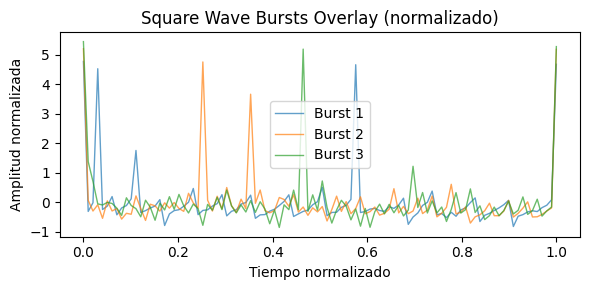

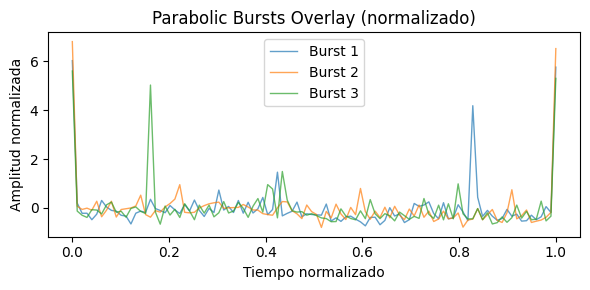

C:\Users\manur\AppData\Local\Temp\ipykernel_18212\4116468208.py:95: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


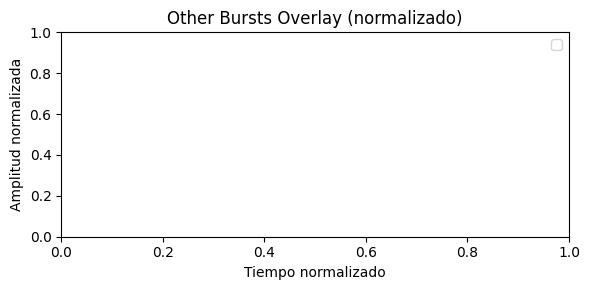

c:\Users\manur\AppData\Local\Programs\Python\Python313\Lib\site-packages\tslearn\shapelets\shapelets.py:353: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
C:\Users\manur\AppData\Local\Temp\ipykernel_18212\4116468208.py:152: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = cm.get_cmap('viridis', 4)


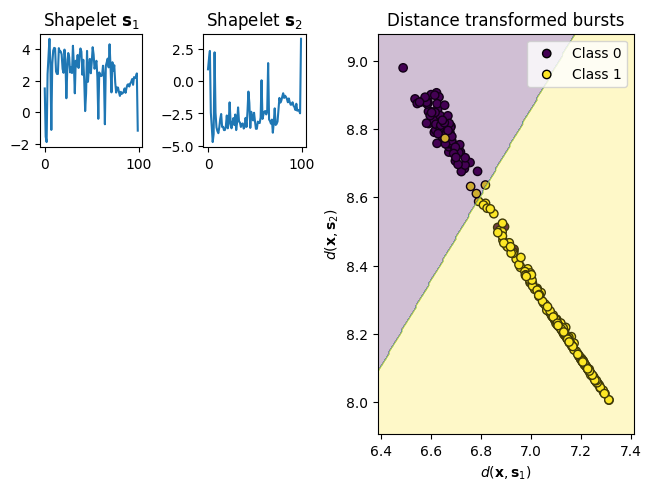

In [1]:
import pyabf
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
from tslearn.preprocessing import TimeSeriesScalerMinMax
from tslearn.shapelets import LearningShapelets
from tensorflow.keras.optimizers import Adam
from matplotlib import cm

# =========================
# ==== Funciones utilitarias ====
# =========================

def load_abf(file_path):
    """Carga y concatena todos los sweeps de un archivo ABF."""
    abf = pyabf.ABF(file_path)
    signals = []
    for i in range(abf.sweepCount):
        abf.setSweep(i)
        signals.append(abf.sweepY)
    signal = np.concatenate(signals)
    dt = 1.0 / abf.dataRate
    time = np.arange(len(signal)) * dt
    return signal, time

def detect_spikes(signal, threshold=-35):
    """Detecta los índices de spikes según un umbral."""
    spike_indices, _ = find_peaks(signal, height=threshold)
    return spike_indices

def detect_bursts(spike_times, burst_threshold=0.3):
    """Detecta bursts usando ISI y devuelve lista de tuplas (start, end)."""
    isi = np.diff(spike_times)
    burst_edges = np.where(isi >= burst_threshold)[0] + 1
    burst_splits = np.split(spike_times, burst_edges)
    bursts = [(b[0], b[-1]) for b in burst_splits if len(b) > 1]
    return bursts

def classify_bursts(bursts, signal, time):
    """Clasifica bursts en Square Wave, Parabolic o Other."""
    square_wave, parabolic, other = [], [], []

    for i, (start, end) in enumerate(bursts):
        mask = (time >= start) & (time <= end)
        burst_min = np.min(signal[mask])

        prev_mean = np.mean(signal[(time > bursts[i-1][1]) & (time < start)]) if i > 0 else np.nan
        next_mean = np.mean(signal[(time > end) & (time < bursts[i+1][0])]) if i < len(bursts)-1 else np.nan
        inter_mean = np.nanmean([prev_mean, next_mean])

        if burst_min > inter_mean:
            square_wave.append((start, end))
        elif burst_min < inter_mean:
            parabolic.append((start, end))
        else:
            other.append((start, end))

    return square_wave, parabolic, other

def normalize_y(signal_segment):
    """Normaliza amplitud con z-score."""
    return (signal_segment - np.mean(signal_segment)) / np.std(signal_segment)

def rescale_x(signal_segment, n_points=100):
    """Reescala señal a n_points por interpolación."""
    f = interp1d(np.linspace(0, 1, len(signal_segment)), signal_segment)
    return f(np.linspace(0, 1, n_points))

def extract_normalized_bursts(burst_list, signal, time, n_points=100):
    """Extrae y normaliza bursts en X e Y para shapelets."""
    normalized_bursts = []
    for start, end in burst_list:
        mask = (time >= start) & (time <= end)
        segment = signal[mask]
        segment_rescaled = rescale_x(segment, n_points)
        segment_normalized = normalize_y(segment_rescaled)
        normalized_bursts.append(segment_normalized)
    return normalized_bursts

def overlay_bursts(burst_list, signal, time, tipo, n=3):
    """Grafica overlay de n bursts normalizados."""
    n_to_plot = min(n, len(burst_list))
    plt.figure(figsize=(6, 3))
    for i in range(n_to_plot):
        start, end = burst_list[i]
        mask = (time >= start) & (time <= end)
        segment = signal[mask]
        segment_rescaled = rescale_x(segment)
        segment_normalized = normalize_y(segment_rescaled)
        plt.plot(np.linspace(0, 1, 100), segment_normalized, lw=1, alpha=0.7, label=f'Burst {i+1}')
    plt.title(f"{tipo} Bursts Overlay (normalizado)")
    plt.xlabel("Tiempo normalizado")
    plt.ylabel("Amplitud normalizada")
    plt.legend()
    plt.tight_layout()
    plt.show()

# =========================
# ==== Pipeline principal ====
# =========================

# --- Cargar señal ---
file_path = "bursting/cell89basal.abf"
signal, time = load_abf(file_path)

# --- Detectar spikes y bursts ---
spike_indices = detect_spikes(signal)
spike_times = time[spike_indices]
bursts = detect_bursts(spike_times)

# --- Clasificar bursts ---
square_wave_bursts, parabolic_bursts, other_bursts = classify_bursts(bursts, signal, time)

# --- Overlay de ejemplo ---
overlay_bursts(square_wave_bursts, signal, time, "Square Wave", n=3)
overlay_bursts(parabolic_bursts, signal, time, "Parabolic", n=3)
overlay_bursts(other_bursts, signal, time, "Other", n=3)

# --- Extraer bursts normalizados ---
n_points = 100
square_bursts_normalized = extract_normalized_bursts(square_wave_bursts, signal, time, n_points)
parabolic_bursts_normalized = extract_normalized_bursts(parabolic_bursts, signal, time, n_points)
other_bursts_normalized = extract_normalized_bursts(other_bursts, signal, time, n_points)

all_normalized_bursts = square_bursts_normalized + parabolic_bursts_normalized + other_bursts_normalized
labels = ([0]*len(square_bursts_normalized) +
          [1]*len(parabolic_bursts_normalized) +
          [2]*len(other_bursts_normalized))

# --- Preparar datos para shapelets ---
X = np.array(all_normalized_bursts)[:, :, np.newaxis]
y = np.array(labels)
X = TimeSeriesScalerMinMax().fit_transform(X)

# --- Entrenar modelo de shapelets ---
n_shapelets_per_size = {n_points: 2}
shp_clf = LearningShapelets(
    n_shapelets_per_size=n_shapelets_per_size,
    weight_regularizer=0.0001,
    optimizer=Adam(0.01),
    max_iter=300,
    verbose=0,
    scale=False,
    random_state=42
)
shp_clf.fit(X, y)

# --- Transformación a 2D y visualización ---
distances = shp_clf.transform(X).reshape((-1, 2))

viridis = cm.get_cmap('viridis', 4)
fig = plt.figure(constrained_layout=True)
gs = fig.add_gridspec(3, 9)
ax_shape1 = fig.add_subplot(gs[0, :2])
ax_shape2 = fig.add_subplot(gs[0, 2:4])
ax_scatter = fig.add_subplot(gs[:, 4:])

# Shapelets
ax_shape1.plot(shp_clf.shapelets_[0].flatten())
ax_shape1.set_title('Shapelet $\\mathbf{s}_1$')
ax_shape2.plot(shp_clf.shapelets_[1].flatten())
ax_shape2.set_title('Shapelet $\\mathbf{s}_2$')

# Scatter plot
for i, label in enumerate(np.unique(y)):
    ax_scatter.scatter(distances[y == label][:, 0],
                       distances[y == label][:, 1],
                       c=[viridis(i / max(1, len(np.unique(y)) - 1))] * np.sum(y == label),
                       edgecolors='k',
                       label=f'Class {label}')

# Decision boundaries
xmin, xmax = distances[:, 0].min() - 0.1, distances[:, 0].max() + 0.1
ymin, ymax = distances[:, 1].min() - 0.1, distances[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.linspace(xmin, xmax, 200), np.linspace(ymin, ymax, 200))

W, b = shp_clf.model_.get_layer("classification").get_weights()
n_classes = len(np.unique(y))

Z = []
for x_val, y_val in np.c_[xx.ravel(), yy.ravel()]:
    if n_classes == 2:
        logit = b[0] + W[0, 0] * x_val + W[1, 0] * y_val
        pred = 1 if logit >= 0 else 0
    else:
        scores = [b[i] + W[0, i] * x_val + W[1, i] * y_val for i in range(n_classes)]
        pred = np.argmax(scores)
    Z.append(pred)

Z = np.array(Z).reshape(xx.shape)
ax_scatter.contourf(xx, yy, Z / max(1, n_classes - 1), cmap=viridis, alpha=0.25)
ax_scatter.set_xlabel('$d(\\mathbf{x}, \\mathbf{s}_1)$')
ax_scatter.set_ylabel('$d(\\mathbf{x}, \\mathbf{s}_2)$')
ax_scatter.set_xlim((xmin, xmax))
ax_scatter.set_ylim((ymin, ymax))
ax_scatter.set_title('Distance transformed bursts')
ax_scatter.legend()
plt.show()